# General RL

#### OpenAI gym environments are used

In [269]:
#import gym
import gym.spaces
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

## Agent 

In [270]:
class Agent:

    def __init__(self, nA=6, alpha = 0.1 , gamma = 1, eps_start = 1, eps_decay = 0.9, eps_min = 0.001, sars = 2):
        """ Initialize agent.

        Params
        ======
        - nA: number of actions available to the agent
        - alpha: update rate 
        - gamma: discount rate
        - epsilon: starting epsilon value
        - eps_decay: epsilon decay value (linear decay)
        - eps_min: the min epsilon
        - sars: the update method (2: sarsamax, 3: expected sars, 4: sars, 0-1: mixture of sarsamax & expectedsars)
        """
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA), dtype=np.float64)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.sars = sars 
    
    def update_epsilon(self): # epsilon update
        """ Updates e-greedy(Q) beginning of each episode
        
        Params
        ======

        Returns
        =======
        - epsilon: updated epsilon value
        """
        return self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min) # e <- e_i


    def select_action(self, state, epsilon): #policy
        """ Given the state, select an action in e-greedy(Q) way
        
        Params
        ======
        - state: the current state of the environment
        - epsilon: the epsilon of e-greedy

        Returns
        =======
        - action: an integer, compatible with the task's action space
        - policy_s: current policy for given state
        """
        policy_s = np.ones(self.nA, dtype=np.float64) * (epsilon / self.nA)
        best_a = np.argmax(self.Q[state])
        policy_s[best_a] = 1 - epsilon + (epsilon / self.nA)
        action = np.random.choice(np.arange(self.nA), p=policy_s)
        return action, policy_s
      
    def step(self, state, action, reward, next_state, done, policy_s): #update step
        """ Update the agent's knowledge-> state-value function (Q), using the most recently sampled tuple.
            
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        - policy_s: the current policy
        """
        Q_update = 0
        if not done: # if done next state Q value is 0
            if self.sars == 0: # sarsamax
                Q_update = np.max(self.Q[next_state])
            
            elif self.sars == 1: #expected sarsa
                Q_update= np.dot(self.Q[next_state], policy_s) 
                
        old_Q = self.Q[state][action]
        self.Q[state][action] = old_Q + (self.alpha * (reward + (self.gamma * Q_update) - old_Q))        

SyntaxError: invalid syntax (<ipython-input-270-e78188d7eb4a>, line 35)

## Monitor

In [280]:
from collections import deque
import sys
import math
import numpy as np

def interact(env, agent, num_episodes=20000, window=100):
    """ Monitor agent's performance.
    
    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        
        epsilon = agent.update_epsilon() # e = e_i
        #agent.alpha = agent.alpha * 0.9999
        # begin the episode
        state = env.reset()
        # initialize the sampled reward
        samp_reward = 0
        while True:
            # agent selects an action
            action, policy_s = agent.select_action(state, epsilon)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done, policy_s)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= window): ## moving average
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                
        #if i_episode % 1000 == 1:
        #    print('alpha', agent.alpha)
        #    print('epsilon', agent.epsilon)
        
        # monitor the progress
        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7: ## Taxi specific
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
        # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_rewards),endpoint=False),np.asarray(avg_rewards))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % window)
    plt.show()
    return avg_rewards, best_avg_reward

## Main of the project 

Episode 20000/20000 || Best average reward 9.226



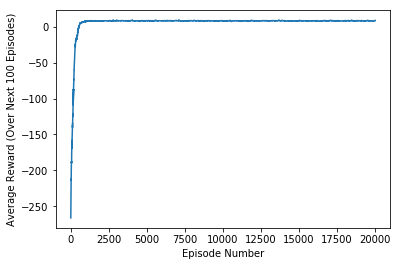

In [281]:

env = gym.make('Taxi-v2')
#env = gym.make('CliffWalking-v0')
nA = env.action_space.n
agent = Agent(nA=nA, alpha=0.2, gamma=1, eps_start=0.0003, eps_decay=0.9, eps_min=0.0001, sars=0) #sars<- 0: sarsamax, 1: ex[sars]
avg_rewards, best_avg_reward = interact(env, agent)  